In [1]:
# General Dependencies
import os
import numpy as np

# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose,\
                        batch_recompose,\
                        overlapping_batch_decompose,\
                        overlapping_batch_recompose,\
                        determine_thresholds
from trefide.reformat import overlapping_component_reformat

# Plotting & Video Rendering Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot
from trefide.video import play_cv2

# Set Demo Dataset Location
ext = os.path.join("../../", "data")
filename = os.path.join(ext, "demoMovie.npy")

%load_ext autoreload
%autoreload 2

### Load Preprocessed Data and set parameters

In [2]:
mov = np.load(filename)
fov_height, fov_width, num_frames = mov.shape

# Generous maximum of rank 50 blocks (safeguard to terminate early if this is hit)
max_components = 50

# Enable Decimation 
max_iters_main = 10
max_iters_init = 40
d_sub = 2
t_sub = 2

# Defaults
consec_failures = 3
tol = 5e-3

# Set Blocksize Parameters
block_height = 40
block_width = 40
overlapping = True
enable_temporal_denoiser = True
enable_spatial_denoiser = True

### Simulate Critical Region Using Noise, determine spatial & temporal threshold

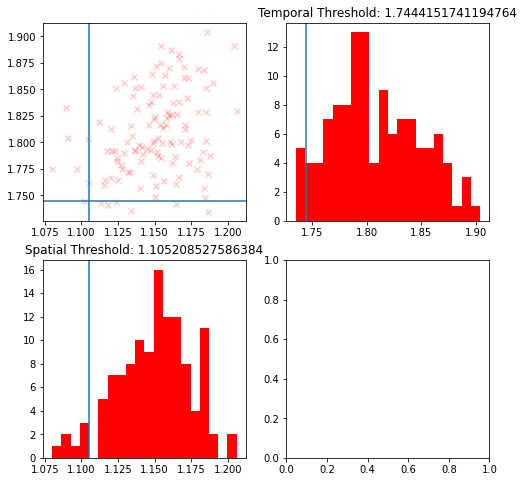

CPU times: user 1min 17s, sys: 1.03 s, total: 1min 18s
Wall time: 13 s


In [3]:
%%time
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, max_iters_main, 
                                                       max_iters_init, tol, 
                                                       d_sub, t_sub, 5, True,
                                                       enable_temporal_denoiser,
                                                       enable_spatial_denoiser)

### Decompose Each Block Into Spatial & Temporal Components

In [4]:
%%time
if not overlapping:    # Blockwise Parallel, Single Tiling
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    spatial_thresh, temporal_thresh,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub, t_sub,
                                    enable_temporal_denoiser, enable_spatial_denoiser)
else:    # Blockwise Parallel, 4x Overlapping Tiling
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                                mov, block_height, block_width,
                                                spatial_thresh, temporal_thresh,
                                                max_components, consec_failures,
                                                max_iters_main, max_iters_init, tol,
                                                d_sub, t_sub,
                                                enable_temporal_denoiser, enable_spatial_denoiser)

CPU times: user 6min 13s, sys: 4.43 s, total: 6min 18s
Wall time: 31.9 s


### Reconstruct Denoised Video

In [5]:
%%time
if not overlapping:  # Single Tiling (No need for reqweighting)
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
else:   # Overlapping Tilings With Reweighting
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights)) 

CPU times: user 24.4 s, sys: 4.24 s, total: 28.7 s
Wall time: 27.8 s


### Produce Diagnostics, Single Tiling Pixel-Wise Ranks

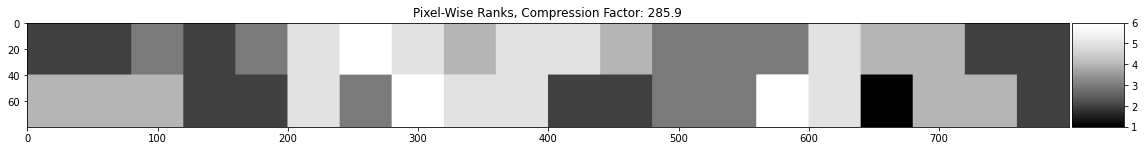

In [6]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

### Correlation Images

Local correlation:  range [-2.8e-02 5.2e-01]
Local correlation:  range [-8.0e-01 1.0e+00]
Local correlation:  range [-5.6e-02 6.7e-02]


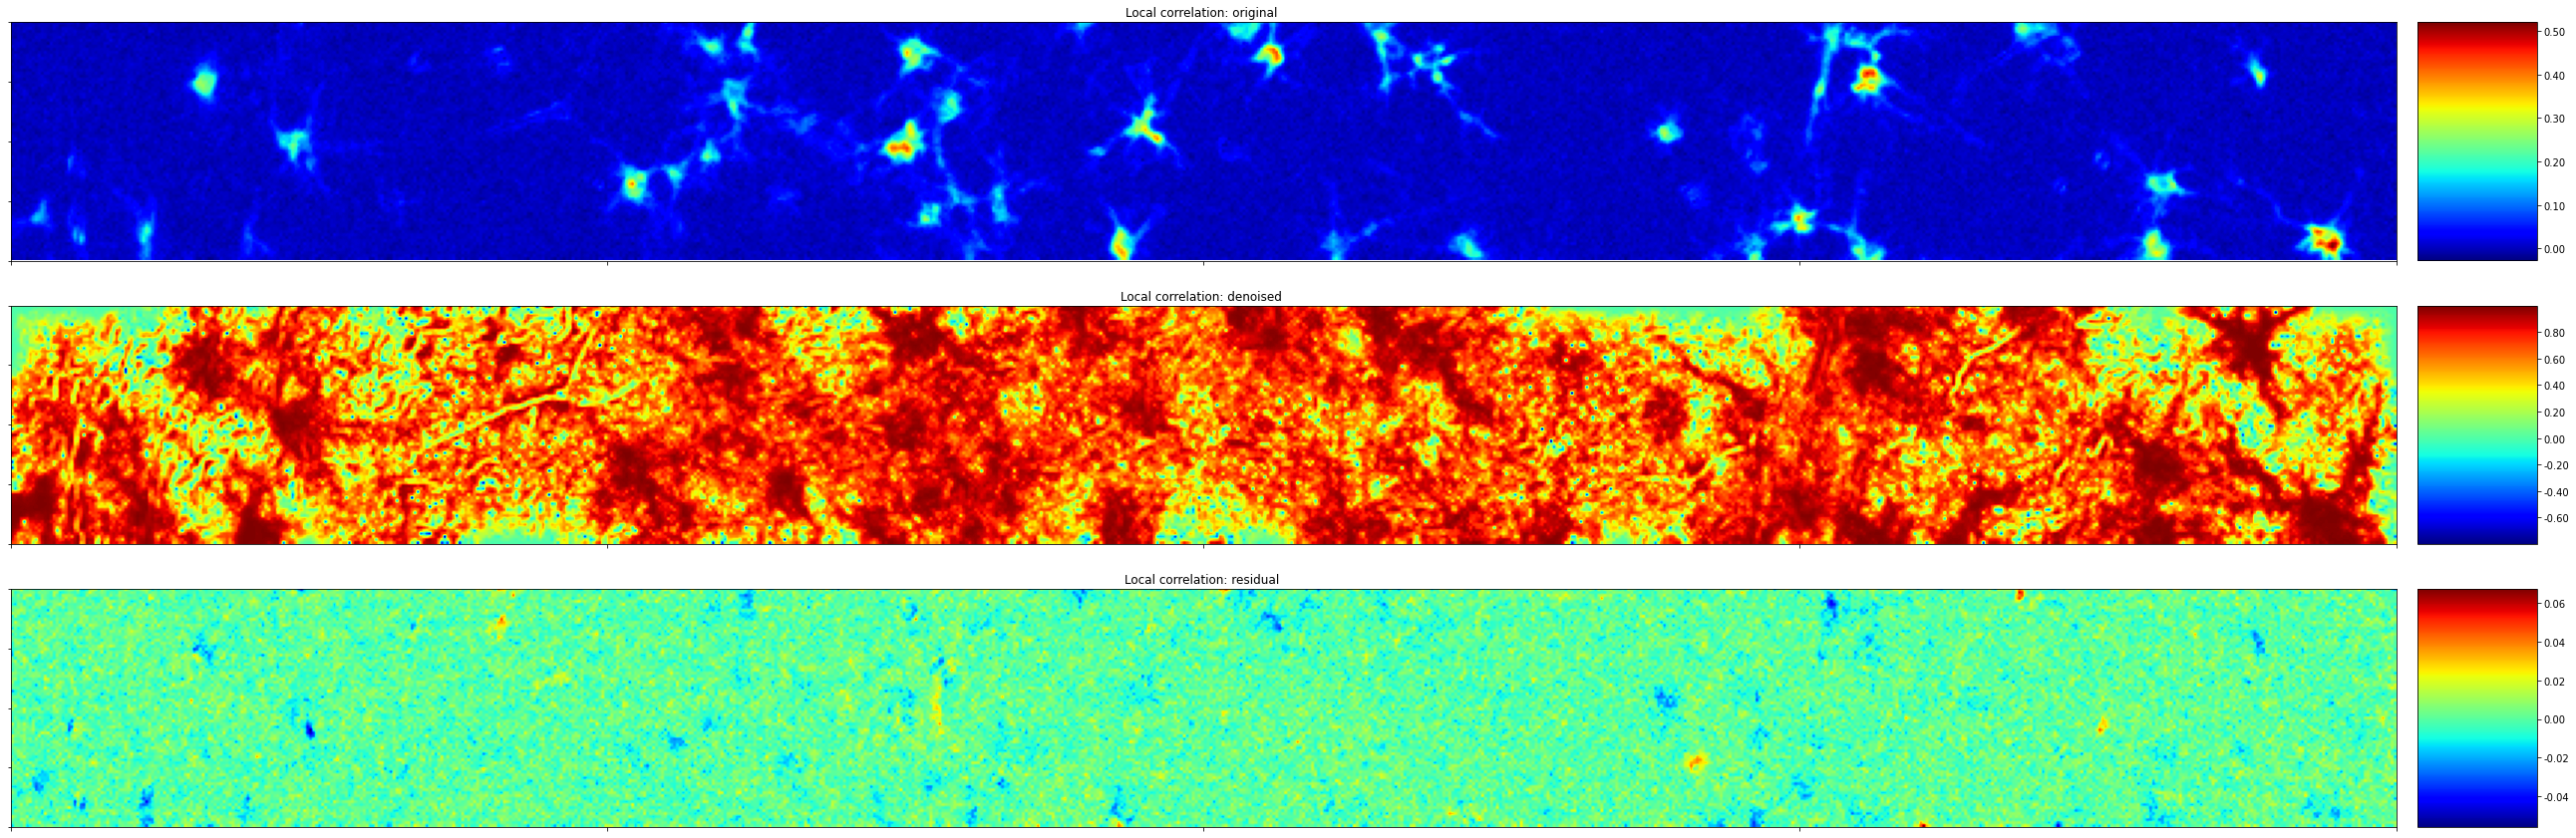

In [7]:
comparison_plot([mov, mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01],
                plot_orientation="horizontal")

### Save Results

In [8]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [9]:
np.savez(os.path.join(ext, "demo_results.npz"), U, V)